<a href="https://colab.research.google.com/github/louisowen6/Cross_Selling_Prediction/blob/master/cross_selling_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross Selling Analysis & Prediction 



# Mount the Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Import Packages

In [0]:
!pip install h2o
!pip install boruta

In [0]:
#Basic
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import math
from scipy.stats import skew

import ast
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans

from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

import h2o
from h2o.automl import H2OAutoML
from h2o.estimators import H2OXGBoostEstimator,H2ORandomForestEstimator,H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator

import xgboost as xgb
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.model_selection import KFold,GridSearchCV,train_test_split
from sklearn.tree import DecisionTreeClassifier

from keras.layers import Input, Dense, Reshape, Embedding
from keras.models import Model
from keras import backend as K
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


# Function definition

Here are the functions used in this notebook (not all)

In [0]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def embedding_transform(df_train,df_val,column,target,epochs):
  '''
  Buat Model dari df_train based on order_id lalu pake model itu untuk predict is_cross_sell dari df_va
  Hasil prediksinya jadi variabell
  '''
  train=df_train.copy()
  val=df_val.copy()
  train[target]=train[target].apply(lambda x: 1 if x=='Yes' else 0)
  val[target]=val[target].apply(lambda x: 1 if x=='Yes' else 0)
  #embedding categorical features
  no_of_unique_cat  = train[column].nunique()
  embedding_size =300
  vocab  = no_of_unique_cat+1

  input_cat = Input(shape=(1,))
  embedding=Embedding(vocab, embedding_size, input_length=1)(input_cat)
  embedding=Reshape(target_shape=(embedding_size,))(embedding)
  x=Dense(5,activation='relu')(embedding)
  x=Dense(2,activation='relu')(embedding)
  output=Dense(1,activation='sigmoid')(x)
  model = Model(input_cat, output)

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_m])
  max_length = 1
  encoded_docs = [one_hot(d, embedding_size) for d in train[column]]
  padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

  encoded_docs_val = [one_hot(d, embedding_size) for d in val[column]]
  padded_docs_val = pad_sequences(encoded_docs_val, maxlen=max_length, padding='post')

  model.fit(padded_docs,train[target].values, epochs=epochs, verbose=1,batch_size=2048
            ,validation_data=(padded_docs_val,val[target].values))
  df_train[column+'_embedding']=model.predict(padded_docs) 
  df_val[column+'_embedding']=model.predict(padded_docs_val)
  df_train=df_train.drop(column,1)
  df_val=df_val.drop(column,1)
  return(df_train,df_val)

def box_hist_plot(df,column):
  '''
  Function for boxplot and histogram in 1 figure
  '''
  plt.figure(figsize=(15,6))
  plt.subplot(1, 2, 1)
  df[[column]].boxplot()

  plt.subplot(1, 2, 2)
  df[column].hist()
  

def detect_outlier(df,column,thres=1.5,plot=False):
  '''
  Function to detect outlier
  '''
  IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
  upper_fence = df[column].quantile(0.75) + (IQR * thres)
  lower_fence = df[column].quantile(0.25)  - (IQR * thres)
  
  print('Upper Fence: {}\n'.format(upper_fence))
  print('Lower Fence: {}\n'.format(lower_fence))
  print('Proportion of Upper Outliers: {}\n'.format(len(df[df[column]>upper_fence])/len(df)*100))
  print('Proportion of Lower Outliers: {}\n'.format(len(df[df[column]<lower_fence])/len(df)*100))
  
  if plot==True:
    box_hist_plot(df,column)

def correlated(df,tolerance):
  '''
  Function to know correlated variables
  Input: {dataframe, correlation_tolerance}
  '''
  cate_features_index = np.where(df.dtypes == 'O')[0]
  num_features_index = [x for x in range(len(df.columns)) if x not in cate_features_index]
  
  #Check correlation of numerical variables
  corrmat = df.iloc[:,num_features_index].corr()
  corrmat = corrmat.abs().unstack() # absolute value of corr coef
  corrmat = corrmat.sort_values(ascending=False)
  corrmat = corrmat[corrmat >= tolerance]
  corrmat = corrmat[corrmat < 1]
  corrmat = pd.DataFrame(corrmat).reset_index()
  corrmat.columns = ['feature1', 'feature2', 'corr']

  # find groups of correlated features

  grouped_feature_ls = []
  correlated_groups = []

  for feature in corrmat.feature1.unique():
    if feature not in grouped_feature_ls:
      # find all features correlated to a single feature
      correlated_block = corrmat[corrmat.feature1 == feature]
      grouped_feature_ls = grouped_feature_ls + list(
      correlated_block.feature2.unique()) + [feature]

      # append the block of features to the list
      correlated_groups.append(correlated_block)

  print('found {} correlated groups'.format(len(correlated_groups)))
  print('out of {} total features'.format(df.iloc[:,num_features_index].shape[1]))

  for group in correlated_groups:
    print(group)
    print()

def ordering_label(df,target,feat):
  '''
  Function for ordering categorical features based on Target feature
  '''
  data=df.copy()
  data[target]=data[target].apply(lambda x: 1 if x=='Yes' else 0)
  ordered_labels = data.groupby(feat).mean()[target].sort_values().index
  ordinal_label = {k:i for i, k in enumerate(ordered_labels, 0)} 
  df[feat]=df[feat].map(ordinal_label)
  return(df)

def detailed_segmentation(df_train,df_val,columns,target,num_segments):
  '''
  Function for detailed segmentation
    
  Number of segments which is not the multiple of 2 will be round down to the nearest
  whole number
  '''
  depth=math.floor(math.log2(num_segments))
  X_train=df_train.drop(target,1)
  y_train=df_train[[target]]
  X_val=df_val.drop(target,1)

  tree_model = DecisionTreeClassifier(max_depth=depth)
    
  for column in columns:
    tree_model.fit(X_train[[column]], y_train)
    df_train[column+'detailed_segment'] = tree_model.predict_proba(X_train[[column]])[:,1]
    df_train=ordering_label(df_train,target,column+'detailed_segment')
    df_val[column+'detailed_segment'] = tree_model.predict_proba(X_val[[column]])[:,1]
    df_val=ordering_label(df_val,target,column+'detailed_segment')
    df_train=df_train.drop(column,1)
    df_val=df_val.drop(column,1)
  return(df_train,df_val)

def mean_encoding(df_train,df_val,columns,target,adjusted=False):
  '''
  Function to create mean encoding
  '''
  train=df_train.copy()
  train[target]=train[target].apply(lambda x: 1 if x=='Yes' else 0)
  for column in columns:
    prob_df = pd.DataFrame(train.groupby([column])[target].mean())
    if adjusted:
      prob_mean = prob_df[target].to_dict()
      train['mean']=train[column].map(prob_mean)
      train.set_index(['order_id'],inplace=True)
      ordered_labels_train=(train['mean']*train['cnt_trx']).to_dict()
      df_train[column+'_adj_mean_encoding']= df_train['order_id'].map(ordered_labels_train)

      val=df_val.copy()
      val[target]=val[target].apply(lambda x: 1 if x=='Yes' else 0)
      #if there is no historical data before then probability of success is assumed same as in the training set
      train_mean=df_train[target].value_counts()['Yes']/len(df_train[target])
      val['mean']=val[column].apply(lambda x: prob_mean[x] if x in prob_mean else train_mean)
      val.set_index(['order_id'],inplace=True)
      ordered_labels_val=(val['mean']*val['cnt_trx']).to_dict()
      df_val[column+'_adj_mean_encoding'] = df_val['order_id'].map(ordered_labels_val)
      df_train=df_train.drop(column,1)
      df_val=df_val.drop(column,1)
    else:
      prob_df['mean']=prob_df['is_cross_sell']
      ordered_labels = prob_df['mean'].to_dict()
      df_train[column+'_mean_encoding'] = df_train[column].map(ordered_labels)
      #if there is no historical data before then probability of success is assumed same as in the training set
      train_mean=df_train[target].value_counts()['Yes']/len(df_train[target])
      df_val[column+'_mean_encoding'] = df_val[column].apply(lambda x: ordered_labels[x] if x in ordered_labels 
                                                            else train_mean)
      df_train=df_train.drop(column,1)
      df_val=df_val.drop(column,1)
  return(df_train,df_val)

def PMI(df_train,df_val,columns):
  '''
  Function to create Pointwise Mutual Information
  '''
  for column in columns:
    toy=df_train.copy()
    toy=toy.sort_values(by=['account_id'])
    toy['is_cross_sell']=toy['is_cross_sell'].apply(lambda x: 1 if x=='Yes' else 0)
    MBA_df=pd.DataFrame(toy.groupby([column])['is_cross_sell'].mean())
    toy_all=toy[['account_id']]
    len_toy_all=len(toy_all)
    toy_pos=toy[toy.is_cross_sell==1][['account_id']]
    len_toy_pos=len(toy_pos)
    acc_id_unique=pd.Series(MBA_df.index.tolist())
    acc_id_pos_unique=pd.Series(MBA_df[MBA_df.is_cross_sell==1].index.tolist())
    #Calculating probability of each account_id
    a=toy_all['account_id'].value_counts()/len_toy_all
    prob_acc_id=acc_id_unique.apply(lambda x: a[x])
    #Calculating Confidence
    b=toy_pos['account_id'].value_counts()/len_toy_pos
    confidence=acc_id_unique.apply(lambda x: b[x] if x in acc_id_pos_unique else 0)
    print('Done confidence')
    #Assigning Values to Dataframe
    MBA_df['lift']=confidence/prob_acc_id
    # MBA_df['adj_PMI']=np.log(1+MBA_df['lift'])
    MBA_df['adj_PMI']=MBA_df['lift']
    adj_PMI=MBA_df['adj_PMI'].to_dict()

    df_train[column+'_adj_PMI'] = df_train[column].map(adj_PMI)
    #if there is no historical data before then probability of that particular account_id is 0 which implies lift=0, so that adj_PMI=0
    df_val[column+'_adj_PMI'] = df_val[column].apply(lambda x: adj_PMI[x] if x in adj_PMI 
                                                           else 0)
    df_train=df_train.drop(column,1)
    df_val=df_val.drop(column,1)
  return(df_train,df_val)    
def WoE(df_train,df_val,columns,target,adjusted=False):
  '''
  Function to create Weight of Evidence
  '''
  train=df_train.copy()
  train[target]=train[target].apply(lambda x: 1 if x=='Yes' else 0)
  for column in columns:
    a = pd.DataFrame(train.groupby([column])[target].mean())
    if adjusted:
      b=pd.DataFrame(train.groupby([column])['is_cross_sell'].count())
      prob_df=a.merge(b,on=column)
      prob_df=prob_df.rename(columns={"is_cross_sell_x": "is_cross_sell", "is_cross_sell_y": "count"})
    else:
      prob_df=a.copy()
    prob_df['not_'+target] = 1-prob_df[target]
    prob_df[prob_df[target] == 0] = 0.000001
    # prob_df[prob_df['not_'+target] == 0] = 0.000001
    if adjusted:
      prob_df['WoE'] = np.log(1+prob_df['count'])*np.log(prob_df[target]/prob_df['not_'+target])
    else:
      prob_df['WoE'] = np.log(prob_df[target]/prob_df['not_'+target])
    ordered_labels = prob_df['WoE'].to_dict()

    df_train[column+'_WoE'] = df_train[column].map(ordered_labels)
    #if there is no historical data before then probability of success is assumed same as in the training set
    df_val[column+'_WoE'] = df_val[column].apply(lambda x: ordered_labels[x] if x in ordered_labels else 
                                                 np.log((0.000001+df_train[target].value_counts()['Yes'])/(df_train[target].value_counts()['No'])) if df_train[target].value_counts()['Yes']==0 else
                                                  np.log((df_train[target].value_counts()['Yes'])/(0.000001+df_train[target].value_counts()['No'])))
    df_train=df_train.drop(column,1)
    df_val=df_val.drop(column,1)
  return(df_train,df_val)

def PCA(df,columns,n_components,scaled=True):
  pca_model = PCA(n_components=n_components)
  if scaled==False:
    scaled_X=rescaling(df,columns,scale_type='Standard')
  else:
    scaled_X=df[columns].copy()
  df_pca = pca_model.fit_transform(scaled_X)
  df_pca=pd.DataFrame(df_pca)
  print('Variance Explained: {}'.format(pca_model.explained_variance_ratio_.cumsum()))
  return(df_pca)

def rescaling(df,columns,scale_type='Standard'):
  '''
  Function for Feature Scaling
  '''
  scale_type=scale_type.lower()
  scaled_X=df.drop(columns,1)
  X=df[columns]
  
  if scale_type=='minmax':
    scaler=MinMaxScaler(feature_range=(0,1))
  elif scale_type=='standard':
    scaler=StandardScaler()

  scaled_column=scaler.fit_transform(X)
  scaled_column=pd.DataFrame(scaled_column,columns=columns)
  for column in columns:
    scaled_X[column]=scaled_column[column].tolist()
  
  return(scaled_X)

def PCA(df,columns,n_components,scaled=True):
  pca_model = PCA(n_components=n_components)
  if scaled==False:
    scaled_X=rescaling(df,columns,scale_type='Standard')
  else:
    scaled_X=df[columns].copy()
  df_pca = pca_model.fit_transform(scaled_X)
  df_pca=pd.DataFrame(df_pca)
  print('Variance Explained: {}'.format(pca_model.explained_variance_ratio_.cumsum()))
  return(df_pca)

def elbow_plot_kmeans(df,columns,kmax,step,scaled=True):
  '''
  Function for kMeans elbow plot
  
  kmax is maximum number of k
  step is looping step for testing kmeans
  '''
  if scaled==False:
    X=rescaling(df,columns,scale_type='Standard')
  else:
    X=df.copy()
  
  WCSS=[]
  for i in range(1,kmax,step):
    kmeans=MiniBatchKMeans(n_clusters=i,init='k-means++',random_state=100,verbose=False)
    kmeans.fit(X)
    WCSS.append(kmeans.inertia_)
    
  plt.plot(range(1,kmax,step),WCSS)
  plt.title('Elbow Method')
  plt.xlabel('Number of Clusters')
  plt.ylabel('WCSS')
  plt.xlim([0,kmax])
  plt.show()

def kmeans(df,columns,k,scaled=True,plot=True):
  '''
  Function for kMeans segmentation
  '''
  if scaled==False:
    X=rescaling(df,columns,scale_type='Standard')
  else:
    X=df[columns].copy()
    
  kmeans=MiniBatchKMeans(n_clusters=k ,init='k-means++',random_state=100,verbose=False)
  y=kmeans.fit(X)
  df['label']=y.labels_.tolist()
  
  if plot==True:
    if len(columns)>2:
      pca = PCA(n_components=3)
      df_pca = pca.fit_transform(X)
      df_pca=pd.DataFrame(df_pca,columns=['pca_1','pca_2','pca_3'])
      fig=plt.figure()
      ax=plt.axes(projection="3d")
      scatter=ax.scatter3D(df_pca.loc[:,'pca_1'],df_pca.loc[:,'pca_2'],df_pca.loc[:,'pca_3'],c=y.labels_,cmap='hsv')
      plt.colorbar(scatter)
      plt.title(str(k)+'-Means Clustering')
      plt.show()
    else:
      scatter=plt.scatter(df.loc[:,columns[0]],df.loc[:,columns[1]],c=y.labels_)
      plt.xlabel(columns[0])
      plt.ylabel(columns[1])
      plt.title(str(k)+'-Means Clustering')
      plt.show()
  return(df)

def segmentation(df_train,df_val,k=9):
  toy=df_train.copy()
  toy['is_cross_sell']=toy['is_cross_sell'].apply(lambda x: 1 if x=='Yes' else 0)
  df_seg=pd.DataFrame(toy.groupby('account_id').mean()['is_cross_sell'])
  df_seg['count']=toy.groupby('account_id').count()['member_duration_days']
  df_seg=df_seg.rename({'member_duration_days':'count'})
  df_seg=kmeans(df_seg[df_seg['count']<20],columns=['is_cross_sell','count'],k=k,scaled=False,plot=False)
  df_seg=ordering_label(df_seg,target='is_cross_sell',feat='label')
  acc_0=df_seg[df_seg.label==0].index.tolist()
  acc_1=df_seg[df_seg.label==1].index.tolist()
  acc_2=df_seg[df_seg.label==2].index.tolist()
  acc_3=df_seg[df_seg.label==3].index.tolist()
  acc_4=df_seg[df_seg.label==4].index.tolist()
  acc_5=df_seg[df_seg.label==5].index.tolist()
  acc_6=df_seg[df_seg.label==6].index.tolist()
  acc_7=df_seg[df_seg.label==7].index.tolist()
  acc_8=df_seg[df_seg.label==8].index.tolist()
  acc_9=df_seg[df_seg['count']>=20].index.tolist()
  df_train['segment']=df_train.account_id.apply(lambda x: 0 if x in acc_0 else 1 if x in acc_1 else 
                                                2 if x in acc_2 else 3 if x in acc_3 else 4 if x in acc_4 else 5 if x in acc_5 else 
                                                6 if x in acc_6 else 7 if x in acc_7 else 8 if x in acc_8 else 9)
  df_val['segment']=df_val.account_id.apply(lambda x: 0 if x in acc_0 else 1 if x in acc_1 else 
                                                2 if x in acc_2 else 3 if x in acc_3 else 4 if x in acc_4 else 5 if x in acc_5 else 
                                                6 if x in acc_6 else 7 if x in acc_7 else 8 if x in acc_8 else 9 if x in acc_9 else
                                                np.nan)
  return(df_train,df_val)

# Import Data

Data used in this modelling process is the flight (CGK-DPS) + hotel transaction history on 2018 from one of the biggest ticketing company in Indonesia 

In [0]:
df_hotel = pd.read_csv('/kaggle/input/datavidia2019/hotel.csv')
df = pd.read_csv('/kaggle/input/datavidia2019/flight.csv')
df_test=pd.read_csv('/kaggle/input/datavidia2019/test.csv')

The target variable in this modelling process is **is_cross_sell** which has value "Yes" when the  **hotel_id** is not *None* and has value "Np" when **hotel_id** is  *None*

In [0]:
df['is_cross_sell']=df['hotel_id'].apply(lambda x: 'Yes' if x !='None' else 'No')

Below is the snippet of flight.csv and hotel.csv data

In [0]:
df.head()

,account_id,order_id,member_duration_days,gender,trip,service_class,price,is_tx_promo,no_of_seats,airlines_name,route,hotel_id,visited_city,log_transaction,is_cross_sell
0,912aa410a02cd7e1bab414214a7005c0,5c6f39c690f23650d3cde28e5b51c908,566.0,M,trip,ECONOMY,885898.00,NO,1.0,33199710eb822fbcfd0dc793f4788d30,CGK - DPS,None,"'['Semarang', 'Jakarta', 'Medan', 'Bali']'","'[545203.03, 918492.11, 1774241.4, 885898.0]'",No
1,d64a90a618202a5e8b25d8539377f3ca,5cbef2b87f51c18bf399d11bfe495a46,607.0,M,trip,ECONOMY,2139751.25,NO,2.0,0a102015e48c1f68e121acc99fca9a05,CGK - DPS,None,"'['Jakarta', 'Medan', 'Bali']'","'[555476.36, 2422826.84, 7398697.64, 7930866.8...",No
2,1a42ac02bcb4a902973123323f84da55,38fc35a1e62384012a358ab1fbd5ad03,648.0,F,trip,ECONOMY,2695550.00,NO,1.0,0a102015e48c1f68e121acc99fca9a05,CGK - DPS,None,"'['Semarang', 'Jakarta', 'Medan', 'Bali']'","'[7328957.45, 7027662.34, 1933360.88, 3461836....",No
3,92cddd64d4be4dec6dfbcc0c50e902f4,c7f54cb748828b4413e02dea2758faf6,418.0,F,trip,ECONOMY,1146665.00,NO,1.0,0a102015e48c1f68e121acc99fca9a05,CGK - DPS,None,"'['Jogjakarta', 'Bali', 'Jakarta', 'Medan']'","'[5243631.69, 2474344.48, 1146665.0]'",No
4,bf637abc47ea93bad22264f4956d67f6,dec228e4d2b6023c9f1fe9cfe9c451bf,537.0,F,trip,ECONOMY,1131032.50,NO,1.0,6c483c0812c96f8ec43bb0ff76eaf716,CGK - DPS,None,"'['Jakarta', 'Bali', 'Medan', 'Jogjakarta', 'S...","'[9808972.98, 9628619.79, 6712680.0, 5034510.0...",No


In [0]:
df_hotel.head()

,hotel_id,starRating,city,free_wifi,pool_access,free_breakfast
0,e2733e84102226acf6b53bffd2e60cf8,0.0,bali,YES,NO,NO
1,9f9de5df06d64ada1026e930687a87e4,0.0,bali,YES,NO,NO
2,3cf6774fb4dc331bb49e7a959b74a67e,0.0,bali,YES,NO,NO
3,eca261898220478834072b0c753a5229,0.0,bali,YES,NO,NO
4,c21f400013fa4f244a7168a3c155b8b5,0.0,bali,YES,NO,NO


# Exploratory data analysis <img src = "https://dryicons.com/icon_download/flat-magnifying-glass-icon-9946" width= 50 align="middle">

## Flight Data 

---
Below is the flight.csv data info

In [0]:
df.info()

Below is the frequency table from ordered  **hotel_id**

In [0]:
pd.DataFrame(df['hotel_id'].value_counts()).head(20)

,hotel_id
None,111198
cd8210b5c97be3564a4cd0283dda323f,178
8631d3e2f6a000ddbfcef3a4a547d642,107
cb1838f895d879993c8ca9eaf729dbeb,94
a3bc533c2761aa779605f68011ee8688,90
e366b55a2e316618559ef5dd0b4a534f,87
50a5b6704042f4abde9e6c365cc5ec24,80
d98370364c38275cf0176b3c037caeb3,78
4f640616d3102097c41affeadb05c606,76
79f4f7137c68a6be56d8b161114e7adb,75


111198 orders have *None* values which means those orders are not classified as cross selling order or it can be said that only around 5% of orders which are classified as cross selling orders, means that this is a *imbalanced* classification problem

---
**account_id**

In [0]:
pd.DataFrame(df['account_id'].value_counts()).head(20)

,account_id
d64a90a618202a5e8b25d8539377f3ca,3311
fbb4123bb341ad85719af86930a0ccea,311
bf637abc47ea93bad22264f4956d67f6,161
74b423f5354172076e9529debf8866ac,145
4944140d10e202e845f0766a3e3ac2d1,133
fabbb09276eea6bcf6cc7baaed9d716a,118
49aef087188299dca09278b382147b44,117
ea9b9a3dc459101446cc47ad48d336c0,106
c3d5f862188aaa1299d0cc99142b4981,105
5634d6fd8d25ce0fd43b00a26d6dc17c,105


There is a user which has more than 3000 transactions in 1 year. This account will be classified as the outliers and will be removed from the data.

In [0]:
print('Unique numbers of acount_id : {}'.format(len(df['account_id'].unique())))

In [0]:
print('Unique numbers of order_id: {}'.format(len(df['order_id'].unique())))

Banyaknya order_id yang unik: 117946


Number of unique **order_id** is same as the number of rows in the data which means there is no duplicated order in the data


---
**member_duration_days**

Below is the descriptive statistics of **member_duration_days**  variable

In [0]:
df[['member_duration_days']].describe()

,member_duration_days
count,117946.000000
mean,955.586955
std,565.292428
min,329.000000
25%,537.000000
50%,678.000000
75%,1341.000000
max,2720.000000


The average member duration for user which has buy a flight tickets is around 2.6 years

It will be check if there is outlier for this variable

Upper Fence: 2547.0

Lower Fence: -669.0

Proportion of Upper Outliers: 0.2916588947484442

Proportion of Lower Outliers: 0.0



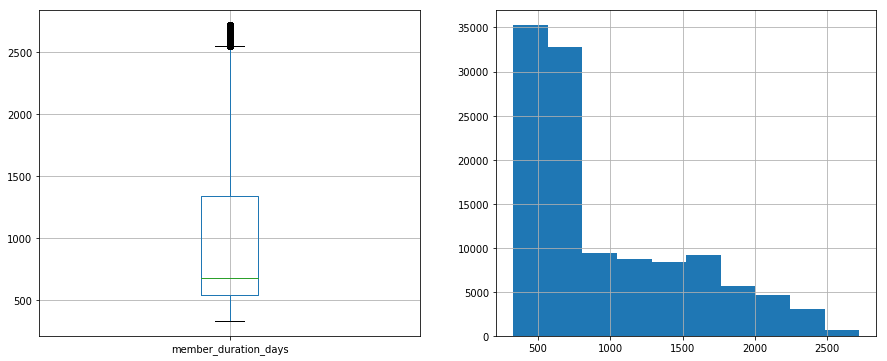

In [0]:
detect_outlier(df,'member_duration_days',plot=True)

From the data plot, **member_duration_days** variable has the skew to the right tendency, resulting some outliers in the high value of this variable (above the upper whisker value)

It will be checked the cross selling behaviour from the outlier users (**member_duration_days** above 2547 days)

In [0]:
df[df['member_duration_days']>2547]['is_cross_sell'].value_counts()/len(df[df['member_duration_days']>2547])*100

No     93.895349
Yes     6.104651
Name: is_cross_sell, dtype: float64

In [0]:
df[df['member_duration_days']<=2547]['is_cross_sell'].value_counts()/len(df[df['member_duration_days']<=2547])*100

No     94.279859
Yes     5.720141
Name: is_cross_sell, dtype: float64

It can be seen that the outlier user still has the similar behaviour with non outlier users

---
**price**

Below is the descriptive statistics for **price** variable

In [0]:
df[['price']].describe()

,price
count,1.179460e+05
mean,2.672772e+06
std,2.449247e+06
min,4.069520e+05
25%,1.282710e+06
50%,1.987061e+06
75%,2.974400e+06
max,5.903643e+07


The average value of price from the user which bough flight ticket is around IDR 2.6 million / transactions

It will be checked if there is an outlier for this variable

Upper Fence: 5511935.0

Lower Fence: -1254825.0

Proportion of Upper Outliers: 8.324148339070423

Proportion of Lower Outliers: 0.0



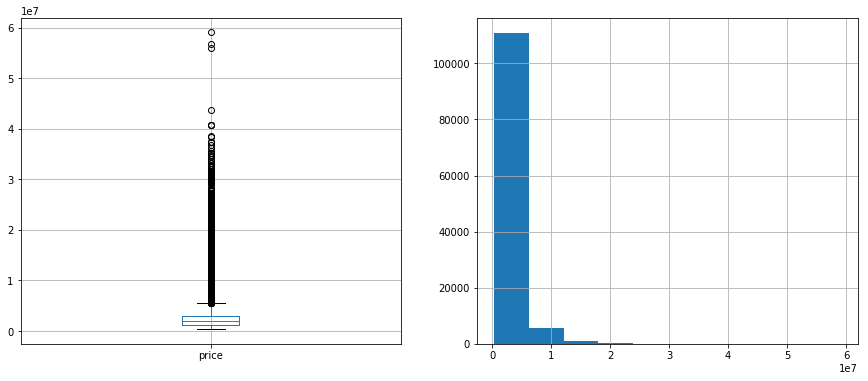

In [0]:
detect_outlier(df,'price',plot=True)

**price** variable has a more positive skewness compared to **member_duration_days**

Same with **member_duration_days**, it will be cheked the cross selling behaviour of the outlier users.

In [0]:
df[df['price']>5511935]['is_cross_sell'].value_counts()/len(df[df['price']>5511935])*100

No     93.786922
Yes     6.213078
Name: is_cross_sell, dtype: float64

In [0]:
df[df['price']<=5511935]['is_cross_sell'].value_counts()/len(df[df['price']<=5511935])*100

No     94.323394
Yes     5.676606
Name: is_cross_sell, dtype: float64

It can be seen that the outlier user still has the similar behaviour with non outlier users

---
**no_of_seats**

Below is the frequency table for **no_of_seats**

In [0]:
df['no_of_seats'].value_counts()

1.0     70937
2.0     29561
3.0      8236
4.0      4963
5.0      2092
6.0      1165
7.0       882
8.0        75
9.0        31
10.0        3
11.0        1
Name: no_of_seats, dtype: int64

We have a hypothesis that the high number of orders caused by the high number of **no_of_seats**

Below is the frequency table of **no_of_seats** from the orders **price** above 5511935

In [0]:
df[df['price']>5511935]['no_of_seats'].value_counts()

4.0     2180
2.0     1933
3.0     1855
5.0     1369
6.0     1037
7.0      861
1.0      475
8.0       73
9.0       31
10.0       3
11.0       1
Name: no_of_seats, dtype: int64

High valued transactions are dominated by the orders which has the high number of **no_of_seats** 

In [0]:
# Checking if there is a pair of variable which are correlated 
correlated(df,0.7)

found 1 correlated groups
out of 3 total features
      feature1 feature2      corr
0  no_of_seats    price  0.712863



Only **price** and **no_of_seats** has a pretty strong correlation value

---
**service_class**

Below is the frequency table for **service_class** variable

In [0]:
df['service_class'].value_counts()

ECONOMY     117665
BUSINESS       281
Name: service_class, dtype: int64

Only around 0.2% of the transactions is the business class flight

---
**gender**

Below is the frequency table for **gender**  variable

In [0]:
df['gender'].value_counts()

M       61036
F       56886
None       24
Name: gender, dtype: int64

Number of transactions transacted by man is higher than transacted by woman. 

There are 24 **Missing Values** for the **gender** variable

---
**is_tx_promo**

Below is the frequency table for  **is_tx_promo** variable

In [0]:
df['is_tx_promo'].value_counts()

NO     67621
YES    50325
Name: is_tx_promo, dtype: int64

Interesting! Order which use promo is pretty enough, almost have 1:1 amount ratio with non promo order

---

## Hotel Data  

Below is the descriptive statistics for **starRating** variable

In [0]:
df_hotel.describe()

,starRating
count,2962.000000
mean,2.992235
std,1.270136
min,0.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


In average, hotel in Bali is 3 star hotel. 

There are 2962 hotels in the data. However, when we check the number of hotels in Bali, there are more than 10000 hotels. This means :
1. Number of hotel in 2019 is way more than 2018; or
2. This hotel data is not complete; or
3. This data only covered the hotel partner with the company

In [0]:
df.groupby('is_cross_sell').median()

,member_duration_days,price,no_of_seats
is_cross_sell,,,
No,675.0,1984060.0,1.0
Yes,831.0,2169960.0,1.0


---
## Join Data

In [0]:
df_join=df.merge(df_hotel,on='hotel_id',how='left')

In [0]:
unique_hotel_id=df_join[df_join.is_cross_sell=='Yes']['hotel_id'].unique()
print('Number of unique hotels transacted by customer: {}'.format(len(unique_hotel_id)))

Number of unique hotels transacted by customer: 675


In [0]:
df_hotel.index=df_hotel.hotel_id

In [0]:
df_hotel.loc[unique_hotel_id]['free_breakfast'].value_counts()

NO     413
YES    182
Name: free_breakfast, dtype: int64

In [0]:
df_hotel.loc[unique_hotel_id]['free_wifi'].value_counts()

YES    593
NO       2
Name: free_wifi, dtype: int64

In [0]:
df_hotel.loc[unique_hotel_id]['pool_access'].value_counts()

NO     592
YES      3
Name: pool_access, dtype: int64

In [0]:
df_hotel.loc[unique_hotel_id]['starRating'].value_counts()

3.0    221
4.0    197
5.0     84
2.0     66
1.0     24
0.0      3
Name: starRating, dtype: int64

The most ordered hotel is 3 star hotel

# Data Cleaning/Pre-processing <img src="https://assets.materialup.com/uploads/0156cdd7-841b-493e-aa15-6ff2692273f7/preview" width = 60>

---
*Missing values* on **gender**

Because there are only 24 missing values, it will be imputed by the most dominant **gender** values which is *M*

In [0]:
df['gender']=df['gender'].apply(lambda x: 'M' if x=='None' else x)

In [0]:
df['airlines_name'].value_counts()

6c483c0812c96f8ec43bb0ff76eaf716    36669
33199710eb822fbcfd0dc793f4788d30    30640
0a102015e48c1f68e121acc99fca9a05    20928
ad5bef60d81ea077018f4d50b813153a    11890
74c5549aa99d55280a896ea50068a211    10751
e35de6a36d385711a660c72c0286154a     7060
9855a1d3de1c46526dde37c5d6fb758c        6
6872b49542519aea7ae146e23fab5c08        2
Name: airlines_name, dtype: int64

In [0]:
df['airlines_name'].value_counts()

6c483c0812c96f8ec43bb0ff76eaf716    36669
33199710eb822fbcfd0dc793f4788d30    30640
0a102015e48c1f68e121acc99fca9a05    20928
ad5bef60d81ea077018f4d50b813153a    11890
74c5549aa99d55280a896ea50068a211    10751
e35de6a36d385711a660c72c0286154a     7060
9855a1d3de1c46526dde37c5d6fb758c        6
6872b49542519aea7ae146e23fab5c08        2
Name: airlines_name, dtype: int64

---


Inconsistent **trip** values

Trip is an categorical variable which has 3 unique values:

*   trip
*   round
* roundtrip

It is a common sense that *round* and *roundtrip* has a same meaning, so the *roundtrip* value is converted into *round*

In [0]:
df['trip']=df['trip'].apply(lambda x: 'round' if x=='roundtrip' else x)

---
**airlines_name** uncommon names

In order to ease the identification process, the airlines name will be converted into 1 char code

In [0]:
df['airlines_name']=df['airlines_name'].apply(lambda x: 'A' if x=='6c483c0812c96f8ec43bb0ff76eaf716' else 'B' if x=='33199710eb822fbcfd0dc793f4788d30' else 'C' if x=='0a102015e48c1f68e121acc99fca9a05' else 
                          'D' if x=='ad5bef60d81ea077018f4d50b813153a' else 'E' if x=='74c5549aa99d55280a896ea50068a211' else 'F' if x=='e35de6a36d385711a660c72c0286154a' else 'G' if x=='9855a1d3de1c46526dde37c5d6fb758c' else 'H')

Based on previous analysis, G and H airlines will be removed from data

In [0]:
df=df[(df['airlines_name']!='G') & (df['airlines_name']!='H')]

---
**account_id** with too many order count will be removed from data


In [0]:
df=df[(df['account_id']!='d64a90a618202a5e8b25d8539377f3ca')]

---
**route** constant values

Because all of the observation in the data is the flight with route Jakarta to Denpasar, then **route** variable is not used in the modelling

In [0]:
df=df.reset_index()
df=df.drop(['route','index'],1)

# Feature Engineering <img src = "https://i1.wp.com/www.edms-consultants.com/wp-content/uploads/2015/05/engineering-icon-e1435823707978.png?fit=250%2C250" width = 50>

The new Features created are as follows:
* **is_refund** , an indicator of refunded transaction. We are assuming that negative transaction means a refunded transaction
* Statistics from  **log_transaction** including mean, standard deviation, count,min,max
* **visited_[city]**, an indicator if the user has visited that city or not. We are not creating **visited_medan**,**visited_denpasar**,**visited_jakarta** variable because all of the users has visited those cities
* **adj_price** , is the result of  **price**  divided by  **no_of_seat**. If the **trip** is classified as *round* trip, then it will be divided by 2
* **price_dif** , is the difference between **adj_price** and  **price** average given the same **service_class** and **airline_names**

There are also some feaures which created when doing the cross validation to prevent overfitting:
* **Woe** (Weight of Evidence) , is the intention of some group did cross selling. $$WoE = ln(\frac{Prob(Yes)}{Prob(Np)})$$ . 
* **Adjusted_Woe**, is the modified version of **WoE** which also take account the number of observation
* **mean_encoding** , is the probability of some group did cross selling


In [0]:
df['log_transaction']=df['log_transaction'].apply(lambda x: ast.literal_eval(x))
df['log_transaction']=df['log_transaction'].apply(lambda x: ast.literal_eval(x))
print('Checking Negative Trx: ')
print(df['log_transaction'].apply(lambda x: "Negative" if any(k<0 for k in x) else "Positive").value_counts())
df['is_refund']=df['log_transaction'].apply(lambda x: "Yes" if any(k<0 for k in x) else "No")
df['min_trx']=df['log_transaction'].apply(lambda x: np.min(x))
df['max_trx']=df['log_transaction'].apply(lambda x: np.max(x))
df['avg_trx']=df['log_transaction'].apply(lambda x: np.mean(x))
df['std_trx']=df['log_transaction'].apply(lambda x: np.std(x))
df['cnt_trx']=df['log_transaction'].apply(lambda x: len(x))
# df['skew_trx']=df['log_transaction'].apply(lambda x: skew(x))

df['visited_jogja']=df['visited_city'].apply(lambda x: 1 if 'Jogjakarta' in x else 0)
df['visited_semarang']=df['visited_city'].apply(lambda x: 1 if 'Semarang' in x else 0)
df['visited_surabaya']=df['visited_city'].apply(lambda x: 1 if 'Surabaya' in x else 0)
df['visited_aceh']=df['visited_city'].apply(lambda x: 1 if 'Aceh' in x else 0)
df['visited_manado']=df['visited_city'].apply(lambda x: 1 if 'Manado' in x else 0)

df['adj_price']=df['price']/(df['no_of_seats'])
df['adj_price']=df.apply(lambda x: (x.adj_price)/2 if x.trip=='round' else x.adj_price ,axis=1)

an = df.airlines_name.unique()
sc = df.service_class.unique()
a=dict()
for i in an:
  for j in sc:
    mean_g = np.mean(df[(df.airlines_name==i)&(df.service_class==j)&(df.is_tx_promo=='NO')]['adj_price'])
    a[i+'_'+j]=mean_g
df['price_dif']=df.apply(lambda x : ((x.adj_price) - a['A_ECONOMY']) if ((x.airlines_name=='A') & (x.service_class=='ECONOMY')) else 
                         ((x.adj_price) - a['B_ECONOMY']) if ((x.airlines_name=='B') & (x.service_class=='ECONOMY')) else 
                         ((x.adj_price) - a['C_ECONOMY']) if ((x.airlines_name=='C') & (x.service_class=='ECONOMY')) else 
                         ((x.adj_price) - a['D_ECONOMY']) if ((x.airlines_name=='D') & (x.service_class=='ECONOMY')) else 
                         ((x.adj_price) - a['E_BUSINESS']) if ((x.airlines_name=='E') & (x.service_class=='BUSINESS')) else 
                         ((x.adj_price) - a['E_ECONOMY']) if ((x.airlines_name=='E') & (x.service_class=='ECONOMY')) else 
                         ((x.adj_price) - a['F_ECONOMY']) if ((x.airlines_name=='F') & (x.service_class=='ECONOMY')) else 
                         np.nan ,axis=1)

df=df.drop(['log_transaction','visited_city','hotel_id'],1)
df_raw=df.copy()
df=df.drop('order_id',1)

Checking Negative Trx: 
Positive    114540
Negative        87
Name: log_transaction, dtype: int64


In [0]:
df.head()

,account_id,member_duration_days,gender,trip,service_class,price,is_tx_promo,no_of_seats,airlines_name,is_cross_sell,...,avg_trx,std_trx,cnt_trx,visited_jogja,visited_semarang,visited_surabaya,visited_aceh,visited_manado,adj_price,price_dif
0,912aa410a02cd7e1bab414214a7005c0,566.0,M,trip,ECONOMY,885898.0,NO,1.0,B,No,...,1.030959e+06,4.533539e+05,4,0,1,0,0,0,885898.0,-3.502775e+05
1,1a42ac02bcb4a902973123323f84da55,648.0,F,trip,ECONOMY,2695550.0,NO,1.0,C,No,...,4.489474e+06,2.250021e+06,5,0,1,0,0,0,2695550.0,1.382226e+06
2,92cddd64d4be4dec6dfbcc0c50e902f4,418.0,F,trip,ECONOMY,1146665.0,NO,1.0,C,No,...,2.954880e+06,1.706745e+06,3,1,0,0,0,0,1146665.0,-1.666595e+05
3,bf637abc47ea93bad22264f4956d67f6,537.0,F,trip,ECONOMY,1131032.5,NO,1.0,A,No,...,4.362199e+06,3.006539e+06,157,1,1,0,0,0,1131032.5,-1.017806e+05
4,fdd499437b284d3c410ba3dfba4fe810,493.0,M,trip,ECONOMY,1457118.0,NO,1.0,D,No,...,5.302909e+06,2.723540e+06,3,0,0,0,0,0,1457118.0,2.025159e+05


# Modelling

Here is the modelling flow:
1. Determining the combination of variables used in the modelling
2. Determining which ML model want to be used
3. Finding the best base parameter using the help of automl function provided by H2O library  
4. Cross-validation manually equipped with added feature engineering

After conduction the experiment of various variables combination, we end up of using this combination:

In [0]:
drop_columns=['service_class','gender','price','is_refund','visited_jogja','visited_semarang','visited_surabaya','visited_aceh','visited_manado']
df.drop(columns=drop_columns).columns

Index(['account_id', 'member_duration_days', 'trip', 'is_tx_promo',
       'no_of_seats', 'airlines_name', 'is_cross_sell', 'min_trx', 'max_trx',
       'avg_trx', 'std_trx', 'cnt_trx', 'adj_price', 'price_dif'],
      dtype='object')

---
## Model 1

Here we find the best base parameter for Random Forest model with the help of automl function provided by H2O library

In [0]:
#Initialize H2O
h2o.init()

drop_columns=['service_class','gender','price','is_refund','visited_jogja','visited_semarang','visited_surabaya','visited_aceh','visited_manado']
drop_columns.append('account_id')

#convert to H2OFrame
df_h2o = h2o.H2OFrame(df.drop(drop_columns,1))

#specify the target and predictor variable
except_target=drop_columns.copy()
except_target.append('is_cross_sell')
x=df.drop(except_target,1).columns.tolist()
y='is_cross_sell'

#using automl with XGBoost Model to help find the best parameter
aml_init = H2OAutoML(max_runtime_secs=3000, balance_classes=False,seed = 1,nfolds=5,stopping_rounds=5,
               sort_metric='logloss',include_algos=['DRF'])
aml_init.train(x = x, y = y, training_frame = df_h2o)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_232"; OpenJDK Runtime Environment (build 1.8.0_232-8u232-b09-1~deb9u1-b09); OpenJDK 64-Bit Server VM (build 25.232-b09, mixed mode)
  Starting server from /opt/conda/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp2gvukfgl
  JVM stdout: /tmp/tmp2gvukfgl/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp2gvukfgl/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 21 days
H2O cluster name:,H2O_from_python_unknownUser_8tzm01
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


In [0]:
#Leaderboard
lb=aml_init.leaderboard
print(lb)

model_id,auc,logloss,mean_per_class_error,rmse,mse
DRF_1_AutoML_20191228_195157,0.709269,0.205704,0.399334,0.226093,0.0511179
XRT_1_AutoML_20191228_195157,0.70957,0.20709,0.406207,0.226194,0.0511637


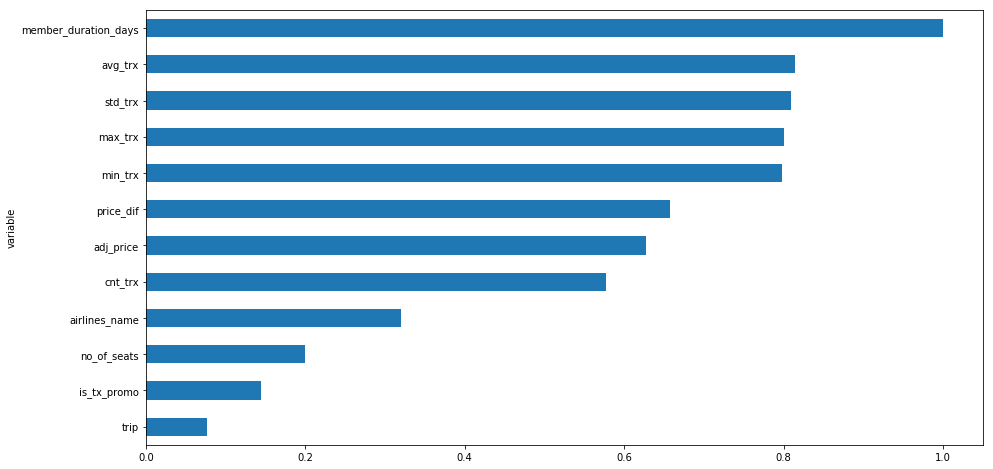

In [0]:
#Variable Importance of Leader Model
m = h2o.get_model(lb[0,"model_id"])
df_imp=m.varimp(use_pandas=True)
df_imp.index=df_imp['variable']

df_imp['scaled_importance'].sort_values().plot.barh(figsize=(15,8))
plt.show()

In [0]:
#DRF
params_DRF = {"ntrees" : aml_init.leader.params['ntrees']['actual']
    , "max_depth" : aml_init.leader.params['max_depth']['actual']
    , "keep_cross_validation_predictions" : aml_init.leader.params['keep_cross_validation_predictions']['actual']
    , "nfolds" : aml_init.leader.params['nfolds']['actual']
    , "nbins" : aml_init.leader.params['nbins']['actual']
    , "nbins_cats" : aml_init.leader.params['nbins_cats']['actual']    
    , "nbins_top_level" : aml_init.leader.params['nbins_top_level']['actual']
    # , "learn_rate_annealing" : aml_init.leader.params['learn_rate_annealing']['actual']
    , "distribution" : aml_init.leader.params['distribution']['actual']
    , "sample_rate" : aml_init.leader.params['sample_rate']['actual']
    , "sample_rate_per_class" : aml_init.leader.params['sample_rate_per_class']['actual']
    # , "col_sample_rate" :aml_init.leader.params['col_sample_rate']['actual']
    , "col_sample_rate_change_per_level" : aml_init.leader.params['col_sample_rate_change_per_level']['actual']
    , "col_sample_rate_per_tree" : aml_init.leader.params['col_sample_rate_per_tree']['actual']
    , "min_rows" : aml_init.leader.params['min_rows']['actual']
    # , "max_abs_leafnode_pred" : aml_init.leader.params['max_abs_leafnode_pred']['actual']
    # , "pred_noise_bandwidth" : aml_init.leader.params['pred_noise_bandwidth']['actual']
    , "categorical_encoding" : aml_init.leader.params['categorical_encoding']['actual']
    # , "min_child_weight" :aml_init.leader.params['min_child_weight']['actual']
    , "seed": aml_init.leader.params['seed']['actual']
    , "score_tree_interval": aml_init.leader.params['score_tree_interval']['actual']
    # , "subsample" :aml_init.leader.params['subsample']['actual']
    # , "max_bins" :aml_init.leader.params['max_bins']['actual']
    # , "max_delta_step" :aml_init.leader.params['max_delta_step']['actual']
    # , "max_leaves" :aml_init.leader.params['max_leaves']['actual']
    # , "booster" :aml_init.leader.params['booster']['actual']
    # , "sample_type" :aml_init.leader.params['sample_type']['actual']
    , "stopping_rounds" :aml_init.leader.params['stopping_rounds']['actual']
    , "stopping_metric" :aml_init.leader.params['stopping_metric']['actual']
    , "stopping_tolerance" :aml_init.leader.params['stopping_tolerance']['actual']
    # , "nthread" :aml_init.leader.params['nthread']['actual']
    # , "eta" :aml_init.leader.params['eta']['actual']
    , "min_split_improvement" :aml_init.leader.params['min_split_improvement']['actual']
    , "histogram_type" : aml_init.leader.params['histogram_type']['actual']
    , "score_each_iteration" : aml_init.leader.params['score_each_iteration']['actual']
    # , "fold_assignment" : aml_init.leader.params['fold_assignment']['actual']
    # , "fold_column" : aml_init.leader.params['fold_column']['actual']
    # , "offset_column" : aml_init.leader.params['offset_column']['actual']
    , "max_runtime_secs" : aml_init.leader.params['max_runtime_secs']['actual']
    , "max_hit_ratio_k" : aml_init.leader.params['max_hit_ratio_k']['actual']
    , "r2_stopping" : aml_init.leader.params['r2_stopping']['actual']
    , "stopping_rounds" : aml_init.leader.params['stopping_rounds']['actual']
    , "stopping_metric" : aml_init.leader.params['stopping_metric']['actual']
    , "stopping_tolerance" : aml_init.leader.params['max_runtime_secs']['actual']
    , "build_tree_one_node" : aml_init.leader.params['build_tree_one_node']['actual']
    , "binomial_double_trees" : aml_init.leader.params['binomial_double_trees']['actual']
    # , "tweedie_power" : aml_init.leader.params['tweedie_power']['actual']
    # , "huber_alpha" : aml_init.leader.params['huber_alpha']['actual']
    , "class_sampling_factors" : aml_init.leader.params['class_sampling_factors']['actual']
    , "max_after_balance_size" : aml_init.leader.params['max_after_balance_size']['actual']
    , "nbins_top_level" : aml_init.leader.params['nbins_top_level']['actual']
    , "calibrate_model" : aml_init.leader.params['calibrate_model']['actual']
    , "mtries" : aml_init.leader.params['mtries']['actual']
    , "custom_metric_func" : aml_init.leader.params['custom_metric_func']['actual']
    # , "custom_distribution_func" : aml_init.leader.params['custom_distribution_func']['actual']
    , "export_checkpoints_dir" : aml_init.leader.params['export_checkpoints_dir']['actual']
    # , "monotone_constraints" : aml_init.leader.params['monotone_constraints']['actual']
    , "check_constant_response" : aml_init.leader.params['check_constant_response']['actual']
    # , "reg_lambda" :aml_init.leader.params['reg_lambda']['actual']
    # , "reg?_alpha" :aml_init.leader.params['reg_alpha']['actual']
}


---
## Model 2

Here we find the best base parameter for GBM with the help of automl function provided by H2O library

In [0]:
#Initialize H2O
h2o.init()

drop_columns=['service_class','gender','price','is_refund','visited_jogja','visited_semarang','visited_surabaya','visited_aceh','visited_manado']
drop_columns.append('account_id')

#convert to H2OFrame
df_h2o = h2o.H2OFrame(df.drop(drop_columns,1))

#specify the target and predictor variable
except_target=drop_columns.copy()
except_target.append('is_cross_sell')
x=df.drop(except_target,1).columns.tolist()
y='is_cross_sell'

#using automl with XGBoost Model to help find the best parameter
aml2_init = H2OAutoML(max_runtime_secs=3000, balance_classes=False,seed = 1,nfolds=5,stopping_rounds=5,
               sort_metric='logloss',include_algos=['GBM'])
aml2_init.train(x = x, y = y, training_frame = df_h2o)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,3 mins 36 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,1 month and 21 days
H2O cluster name:,H2O_from_python_unknownUser_8tzm01
H2O cluster total nodes:,1
H2O cluster free memory:,3.320 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


In [0]:
#Leaderboard
lb=aml_init.leaderboard
print(lb)

model_id,auc,logloss,mean_per_class_error,rmse,mse
DRF_1_AutoML_20191228_195157,0.709269,0.205704,0.399334,0.226093,0.0511179
XRT_1_AutoML_20191228_195157,0.70957,0.20709,0.406207,0.226194,0.0511637


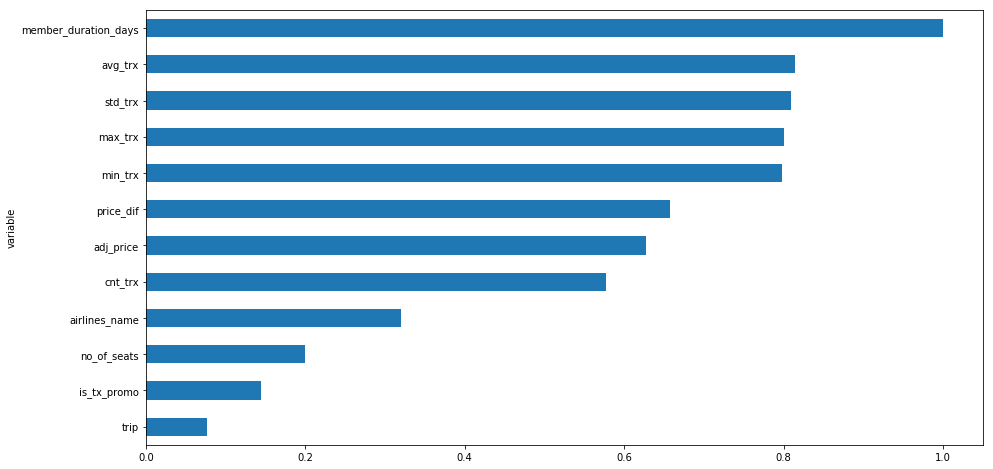

In [0]:
#Variable Importance of Leader Model
m = h2o.get_model(lb[0,"model_id"])
df_imp=m.varimp(use_pandas=True)
df_imp.index=df_imp['variable']

df_imp['scaled_importance'].sort_values().plot.barh(figsize=(15,8))
plt.show()

In [0]:
#gbm
params_GBM = {"ntrees" : aml2_init.leader.params['ntrees']['actual']
    , "max_depth" : aml2_init.leader.params['max_depth']['actual']
    , "keep_cross_validation_predictions" : aml2_init.leader.params['keep_cross_validation_predictions']['actual']
    , "nfolds" : aml2_init.leader.params['nfolds']['actual']
    , "nbins" : aml2_init.leader.params['nbins']['actual']
    , "nbins_cats" : aml2_init.leader.params['nbins_cats']['actual']
    , "learn_rate" : aml2_init.leader.params['learn_rate']['actual']
    , "learn_rate_annealing" : aml2_init.leader.params['learn_rate_annealing']['actual']
    , "distribution" : aml2_init.leader.params['distribution']['actual']
    , "sample_rate" : aml2_init.leader.params['sample_rate']['actual']
    , "sample_rate_per_class" : aml2_init.leader.params['sample_rate_per_class']['actual']
    , "col_sample_rate" :aml2_init.leader.params['col_sample_rate']['actual']
    , "col_sample_rate_change_per_level" : aml2_init.leader.params['col_sample_rate_change_per_level']['actual']
    , "col_sample_rate_per_tree" : aml2_init.leader.params['col_sample_rate_per_tree']['actual']
    , "min_rows" : aml2_init.leader.params['min_rows']['actual']
    , "max_abs_leafnode_pred" : aml2_init.leader.params['max_abs_leafnode_pred']['actual']
    , "pred_noise_bandwidth" : aml2_init.leader.params['pred_noise_bandwidth']['actual']
    , "categorical_encoding" : aml2_init.leader.params['categorical_encoding']['actual']
    , "seed": aml2_init.leader.params['seed']['actual']
    , "score_tree_interval": aml2_init.leader.params['score_tree_interval']['actual']
    , "stopping_rounds" :aml2_init.leader.params['stopping_rounds']['actual']
    , "stopping_metric" :aml2_init.leader.params['stopping_metric']['actual']
    , "stopping_tolerance" :aml2_init.leader.params['stopping_tolerance']['actual']
    , "min_split_improvement" :aml2_init.leader.params['min_split_improvement']['actual']
    , "histogram_type" : aml2_init.leader.params['histogram_type']['actual']
    , "score_each_iteration" : aml2_init.leader.params['score_each_iteration']['actual']
    , "max_hit_ratio_k" : aml2_init.leader.params['max_hit_ratio_k']['actual']
    , "r2_stopping" : aml2_init.leader.params['r2_stopping']['actual']
    , "stopping_rounds" : aml2_init.leader.params['stopping_rounds']['actual']
    , "stopping_metric" : aml2_init.leader.params['stopping_metric']['actual']
    , "stopping_tolerance" : aml2_init.leader.params['max_runtime_secs']['actual']
    , "build_tree_one_node" : aml2_init.leader.params['build_tree_one_node']['actual']
    , "quantile_alpha" : aml2_init.leader.params['quantile_alpha']['actual']
    , "tweedie_power" : aml2_init.leader.params['tweedie_power']['actual']
    , "huber_alpha" : aml2_init.leader.params['huber_alpha']['actual']
    , "class_sampling_factors" : aml2_init.leader.params['class_sampling_factors']['actual']
    , "max_after_balance_size" : aml2_init.leader.params['max_after_balance_size']['actual']
    , "nbins_top_level" : aml2_init.leader.params['nbins_top_level']['actual']
    , "calibrate_model" : aml2_init.leader.params['calibrate_model']['actual']
    , "custom_metric_func" : aml2_init.leader.params['custom_metric_func']['actual']
    , "custom_distribution_func" : aml2_init.leader.params['custom_distribution_func']['actual']
    , "export_checkpoints_dir" : aml2_init.leader.params['export_checkpoints_dir']['actual']
    , "monotone_constraints" : aml2_init.leader.params['monotone_constraints']['actual']
    , "check_constant_response" : aml2_init.leader.params['check_constant_response']['actual']
}

params_GBM['seed'] = params_DRF['seed']

---
## K-Fold Cross Validation

Below is the function definition for K-Fold cross validation for single model and ensemble model

In [0]:
def cross_val(df,drop_columns,f1_threshold,params,nfolds,model='drf',is_feat_eng=False,label_not_cross_sell=False,is_binning=True,is_WoE=False,adjusted_WoE=True,is_mean_encode=True,adjusted_mean=False,is_segment=False,is_PMI=False,is_embedding=False):
  f1_list=[]
  #Initiate StratifiedKFold Class
  kfold = KFold(n_splits=nfolds, shuffle=True, random_state=500)
  #Drop Columns
  if len(drop_columns)>0:
    df=df.drop(drop_columns,1)
  #begin looping
  for train,val in kfold.split(df):
    df_train=df.loc[train,:]
    df_val=df.loc[val,:]

    #Feature Engineering
    if is_feat_eng:
      if label_not_cross_sell:
        #Creating list of customer which has number of orders more than 50
        acc=pd.DataFrame(df_train['account_id'].value_counts())
        top_acc_list=acc[acc.account_id>50].index.tolist()
        #Creating list of customer which never done cross selling
        toy=df_train.copy()
        toy['is_cross_sell']=toy['is_cross_sell'].apply(lambda x: 1 if x=='Yes' else 0)
        cross_sell_prop=pd.DataFrame(toy.groupby('account_id').mean()['is_cross_sell'])
        no_cross_sell_list=cross_sell_prop[cross_sell_prop['is_cross_sell']==0].index.tolist()
        #Creating  list of customer which has number of orders more than 50 and never done cross selling
        not_cross_sell_account_id=df_train[(df_train['account_id'].isin(top_acc_list)) & (df_train['account_id'].isin(no_cross_sell_list))]['account_id'].unique().tolist()

        df_train['label_not_cross_sell']=df_train['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
        df_val['label_not_cross_sell']=df_val['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
      if is_segment:
        df_train,df_val=segmentation(df_train,df_val,k=4)
      if is_PMI:
        df_train,df_val=PMI(df_train,df_val,columns=['account_id'])
      if is_WoE:
        df_train,df_val=WoE(df_train,df_val,columns=['airlines_name'],target='is_cross_sell',adjusted=adjusted_WoE)
      if is_mean_encode:
        df_train,df_val=mean_encoding(df_train,df_val,columns=['account_id'],target='is_cross_sell',adjusted=adjusted_mean)
      if is_binning:
        df_train,df_val=detailed_segmentation(df_train,df_val,columns=['member_duration_days','price'],target='is_cross_sell',num_segments=5)
      if is_embedding:
         df_train,df_val=embedding_transform(df_train,df_val,column='order_id',target='is_cross_sell',epochs=50)
      if 'account_id' in df_train.columns:
        df_train,df_val=df_train.drop('account_id',1),df_val.drop('account_id',1)
      if 'order_id' in df_train.columns:
        df_train,df_val=df_train.drop('order_id',1),df_val.drop('order_id',1)
      print('Done Feature Engineering!')
    else:
      df_train,df_val=df_train.drop(['account_id','order_id'],1),df_val.drop(['account_id','order_id'],1)

    df_train_h2o = h2o.H2OFrame(df_train)
    df_val_h2o = h2o.H2OFrame(df_val)
    #specify the target and predictor variable
    x=df_train.drop('is_cross_sell',1).columns.tolist()
    y='is_cross_sell'

    if model=='gbm':
      #Initiate Model
      model_gbm = H2OGradientBoostingEstimator(**params_GBM)
      model_gbm.train(x = x, y = y, training_frame = df_train_h2o,validation_frame = df_val_h2o)
      #Variable Importance Plot
      df_imp=model_gbm.varimp(use_pandas=True)
      df_imp.index=df_imp['variable']
      df_imp['scaled_importance'].sort_values().plot.barh(figsize=(15,8))
      plt.show()
      #Data Validation Prediction
      prediction_prob = model_gbm.predict(df_val_h2o)[:,2]
      prediction_prob=prediction_prob.as_data_frame()['Yes']
    elif model=='drf':
      #Initiate Model
      model_drf = H2ORandomForestEstimator(**params_DRF)
      model_drf.train(x = x, y = y, training_frame = df_train_h2o,validation_frame = df_val_h2o)
      #Variable Importance Plot
      df_imp=model_drf.varimp(use_pandas=True)
      df_imp.index=df_imp['variable']
      df_imp['scaled_importance'].sort_values().plot.barh(figsize=(15,8))
      plt.show()
      prediction_prob = model_drf.predict(df_val_h2o)[:,2]
      prediction_prob=prediction_prob.as_data_frame()['Yes']
    #Test various number of threshold for classifying "Yes" or "No"
    for k in f1_threshold :
        prediction=prediction_prob.apply(lambda x: "Yes" if x>k else "No")
        # calculate the new F1
        precision=confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]/(confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]+confusion_matrix(df_val['is_cross_sell'],prediction)[0][1])
        recall=confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]/(confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]+confusion_matrix(df_val['is_cross_sell'],prediction)[1][0])
        f1=2*precision*recall/(precision+recall)
#         print('Threshold : {}, F1 Score: {}'.format(k,f1))
        f1_list.append(f1)
  hasil = pd.DataFrame(np.array(f1_list).reshape(5,len(f1_threshold)).transpose())
  hasil.index = f1_threshold
  hasil['mean'] = hasil.mean(axis=1)
  hasil['std']=hasil.std(axis=1)
  return hasil

In [0]:
def cross_val_ensemble(df,drop_columns,f1_threshold,nfolds,model1='DRF',model2='GBM',is_feat_eng=False,label_not_cross_sell=False,is_binning=True,is_WoE=False,adjusted_WoE=False,is_mean_encode=True,adjusted_mean=False,is_segment=False):
  f1_list=[]
  #Initiate StratifiedKFold Class
  kfold = KFold(n_splits=nfolds, shuffle=True, random_state=500)
  #Drop Columns
  if len(drop_columns)>0:
    df=df.drop(drop_columns,1)
  #begin looping
  for train,val in kfold.split(df):
    df_train=df.loc[train,:]
    df_val=df.loc[val,:]

    #Feature Engineering
    if is_feat_eng:
      if label_not_cross_sell:
        #Creating list of customer which has number of orders more than 50
        acc=pd.DataFrame(df_train['account_id'].value_counts())
        top_acc_list=acc[acc.account_id>50].index.tolist()
        #Creating list of customer which never done cross selling
        toy=df_train.copy()
        toy['is_cross_sell']=toy['is_cross_sell'].apply(lambda x: 1 if x=='Yes' else 0)
        cross_sell_prop=pd.DataFrame(toy.groupby('account_id').mean()['is_cross_sell'])
        no_cross_sell_list=cross_sell_prop[cross_sell_prop['is_cross_sell']==0].index.tolist()
        #Creating  list of customer which has number of orders more than 50 and never done cross selling
        not_cross_sell_account_id=df_train[(df_train['account_id'].isin(top_acc_list)) & (df_train['account_id'].isin(no_cross_sell_list))]['account_id'].unique().tolist()

        df_train['label_not_cross_sell']=df_train['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
        df_val['label_not_cross_sell']=df_val['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
      if is_segment:
        df_train,df_val=segmentation(df_train,df_val,k=4)
      if is_WoE:
        df_train,df_val=WoE(df_train,df_val,columns=['airlines_name'],target='is_cross_sell',adjusted=adjusted_WoE)
      if is_mean_encode:
        df_train,df_val=mean_encoding(df_train,df_val,columns=['account_id'],target='is_cross_sell',adjusted=adjusted_mean)
      if is_binning:
        df_train,df_val=detailed_segmentation(df_train,df_val,columns=['member_duration_days','price'],target='is_cross_sell',num_segments=5)
      if 'account_id' in df_train.columns:
        df_train,df_val=df_train.drop('account_id',1),df_val.drop('account_id',1)
      if 'order_id' in df_train.columns:
        df_train,df_val=df_train.drop('order_id',1),df_val.drop('order_id',1)
      print('Done Feature Engineering!')
    else:
      df_train,df_val=df_train.drop('account_id',1),df_val.drop('account_id',1)

    df_train_h2o = h2o.H2OFrame(df_train)
    df_val_h2o = h2o.H2OFrame(df_val)
    #specify the target and predictor variable
    x=df_train.drop('is_cross_sell',1).columns.tolist()
    y='is_cross_sell'

    #Initiate Model
    # model_GBM = H2OXGBoostEstimator(**params)
    if(model1=='DRF'):
      model_1 = H2ORandomForestEstimator(**params_DRF)
    elif(model1=='GBM'):
      model_1 = H2OGradientBoostingEstimator(**params_GBM)
    else :
      raise ValueError('Model tidak terdaftar')

    if(model2=='DRF'):
      model_2 = H2ORandomForestEstimator(**params_DRF)
    elif(model2=='GBM'):
      model_2 = H2OGradientBoostingEstimator(**params_GBM)
    else :
      raise ValueError('Model tidak terdaftar') 
    list_models=[model_1, model_2]
    
    model_1.train(x = x, y = y, training_frame = df_train_h2o,validation_frame = df_val_h2o)
    model_2.train(x = x, y = y, training_frame = df_train_h2o,validation_frame = df_val_h2o)
    
    ensemble = H2OStackedEnsembleEstimator(base_models=list_models)
    ensemble.train(x = x, y = y, training_frame = df_train_h2o,validation_frame = df_val_h2o)

    prediction = ensemble.predict(df_val_h2o)[:,2]
    prediction_prob=prediction.as_data_frame()['Yes']
    for k in f1_threshold :
        prediction=prediction_prob.apply(lambda x: "Yes" if x>k else "No")
        # calculate the new F1
        precision=confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]/(confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]+confusion_matrix(df_val['is_cross_sell'],prediction)[0][1])
        recall=confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]/(confusion_matrix(df_val['is_cross_sell'],prediction)[1][1]+confusion_matrix(df_val['is_cross_sell'],prediction)[1][0])
        f1=2*precision*recall/(precision+recall)
#         print('Threshold : {}, F1 Score: {}'.format(k,f1))
        f1_list.append(f1)
  hasil = pd.DataFrame(np.array(f1_list).reshape(5,len(f1_threshold)).transpose())
  hasil.index = f1_threshold
  hasil['mean'] = hasil.mean(axis=1)
  hasil['std']=hasil.std(axis=1)
  return hasil

## DRF Tuning

Finding the best threshold so we got the highest F1-Score

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


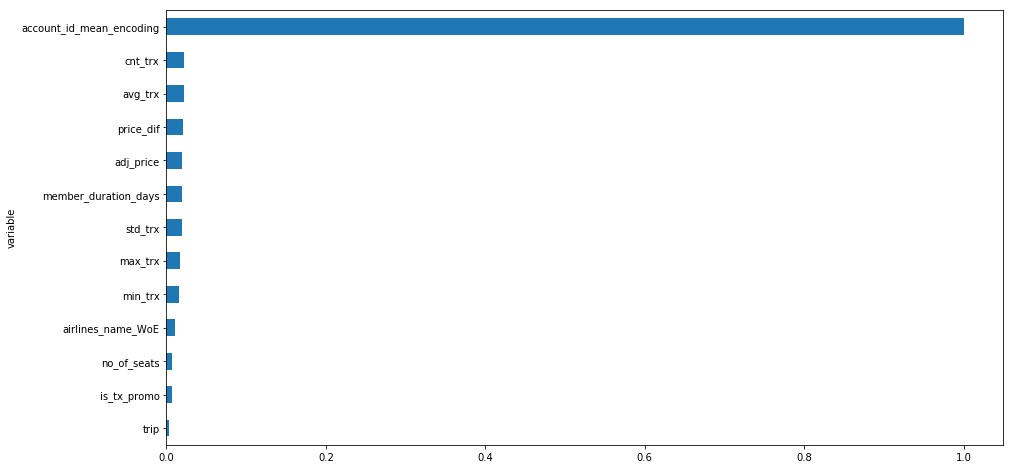

drf prediction progress: |████████████████████████████████████████████████| 100%
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


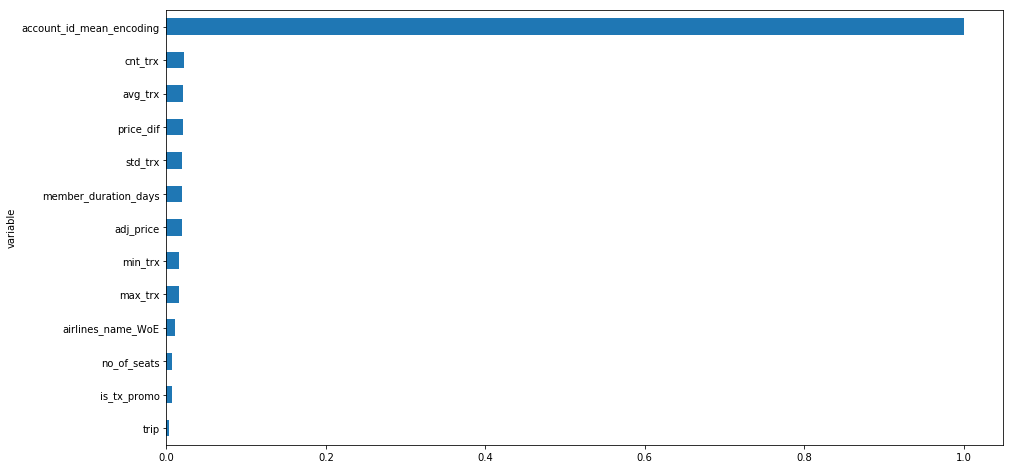

drf prediction progress: |████████████████████████████████████████████████| 100%
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


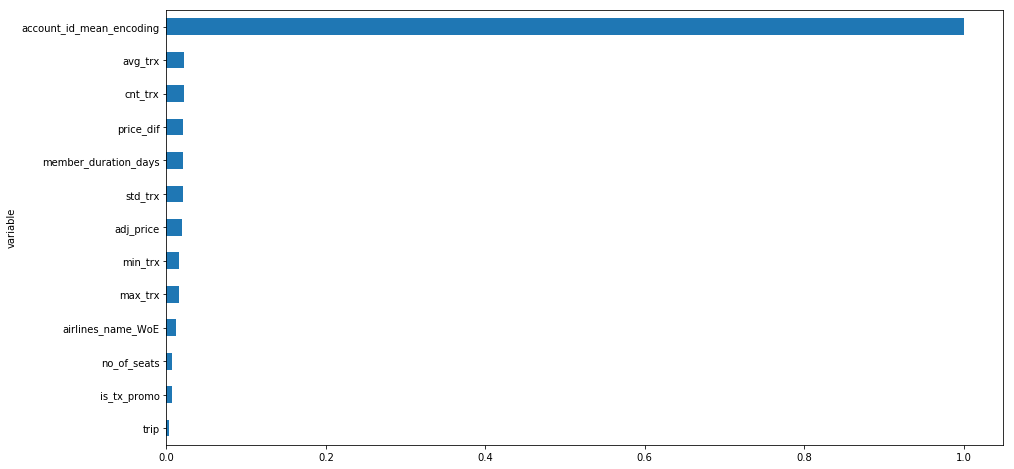

drf prediction progress: |████████████████████████████████████████████████| 100%
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


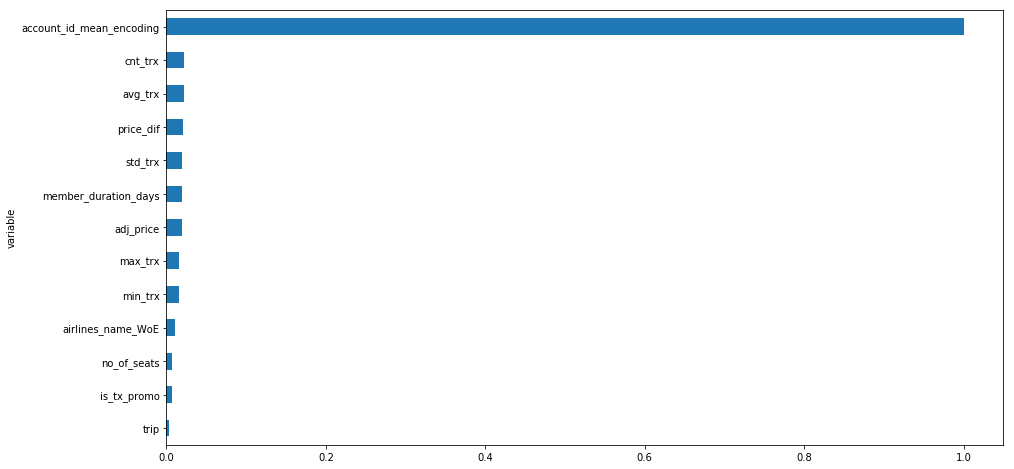

drf prediction progress: |████████████████████████████████████████████████| 100%
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


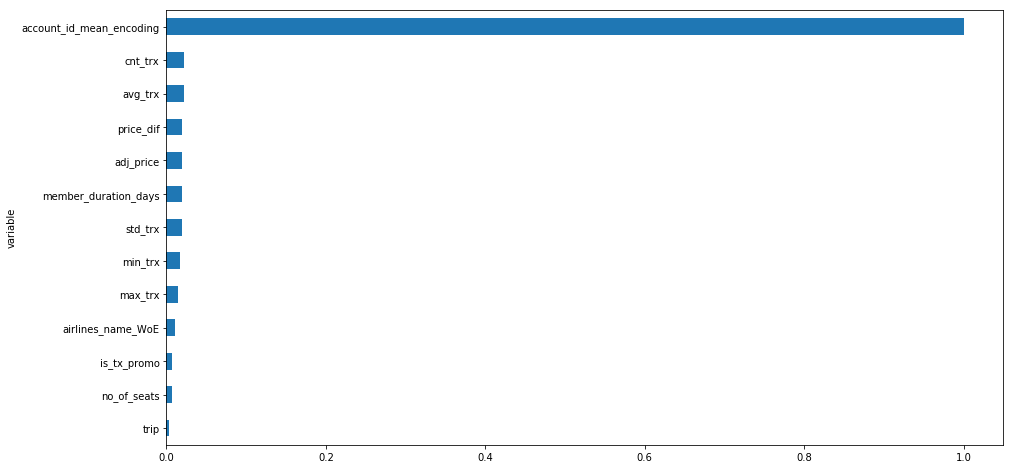

drf prediction progress: |████████████████████████████████████████████████| 100%


,0,1,2,3,4,mean,std
0.285,0.435625,0.414667,0.426740,0.425866,0.431539,0.426888,0.007048
0.270,0.434902,0.413483,0.425976,0.426740,0.431978,0.426616,0.007353
0.295,0.434863,0.415490,0.427650,0.425453,0.429180,0.426527,0.006337
0.280,0.435343,0.414447,0.425765,0.425610,0.431465,0.426526,0.007063
0.290,0.434381,0.414169,0.426997,0.426123,0.430667,0.426467,0.006810
...,...,...,...,...,...,...,...
0.020,0.161999,0.175869,0.173567,0.166653,0.164222,0.168462,0.005366
0.015,0.162457,0.175735,0.173409,0.166444,0.164147,0.168438,0.005218
0.010,0.160664,0.174537,0.172941,0.164846,0.163939,0.167385,0.005395
0.005,0.160202,0.173884,0.172194,0.163232,0.163736,0.166650,0.005382


In [0]:
tune_df=cross_val(df_raw,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell') & (x!='order_id') & (x!='cnt_trx') & (x!='airlines_name')],
                  f1_threshold=np.arange(0.0,0.45,0.005),params=params_DRF,nfolds=5,model='drf',is_feat_eng=True,is_binning=False,is_WoE=True,adjusted_WoE=True,
                  is_mean_encode=True,adjusted_mean=False,is_segment=False,is_PMI=False,is_embedding=False)
tune_df.sort_values(by='mean',ascending=False)

In [0]:
best_f1_DRF=tune_df.sort_values(by='mean',ascending=False).index[0]

# GBM Tuning

Finding the best threshold so we got the highest F1-Score

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%


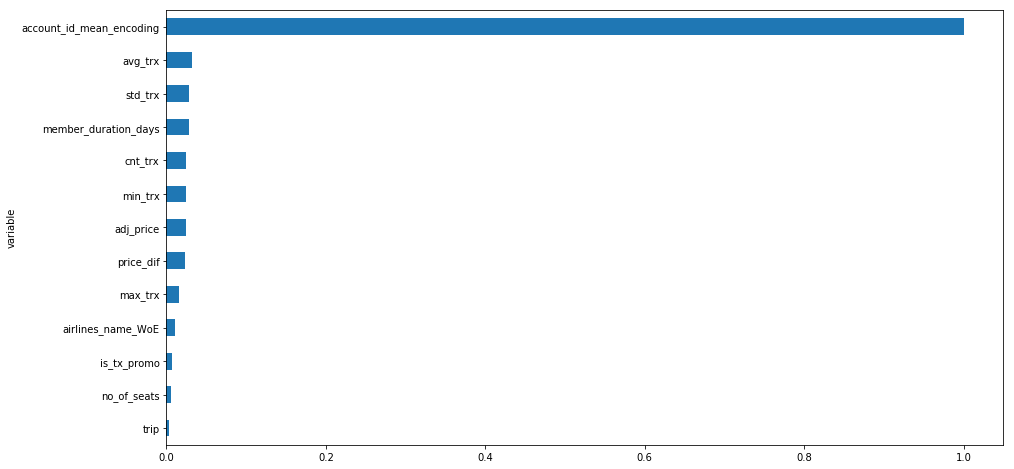

gbm prediction progress: |████████████████████████████████████████████████| 100%
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%


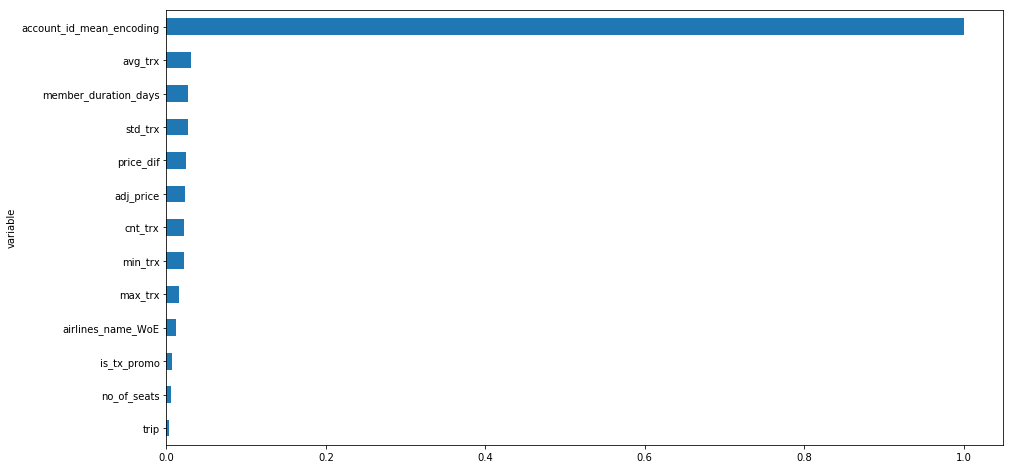

gbm prediction progress: |████████████████████████████████████████████████| 100%
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%


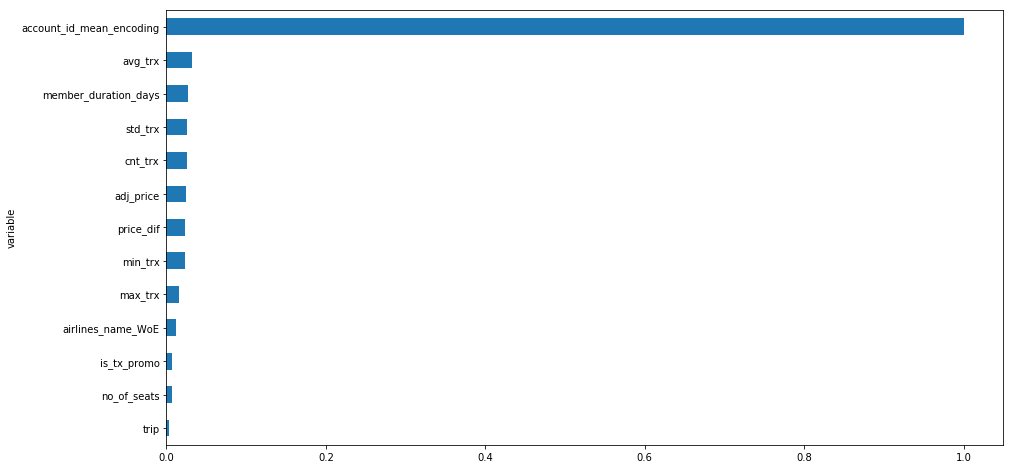

gbm prediction progress: |████████████████████████████████████████████████| 100%
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%


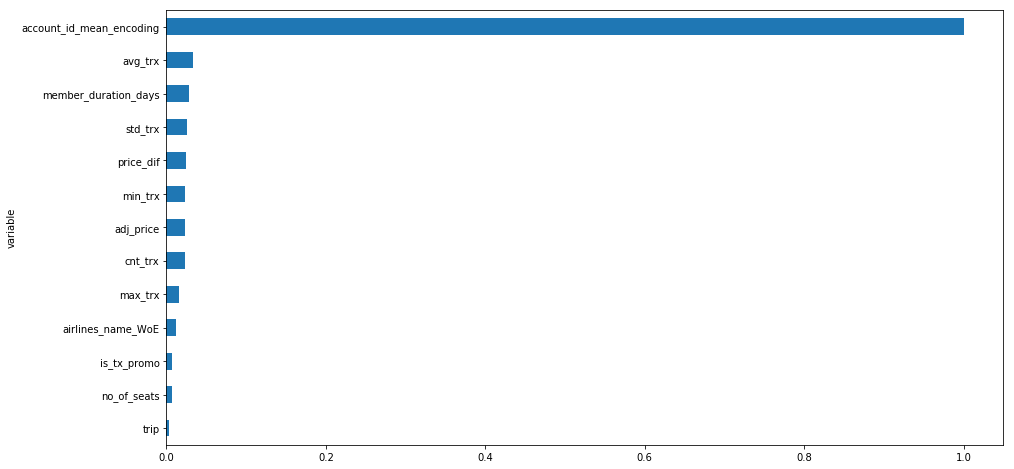

gbm prediction progress: |████████████████████████████████████████████████| 100%
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%


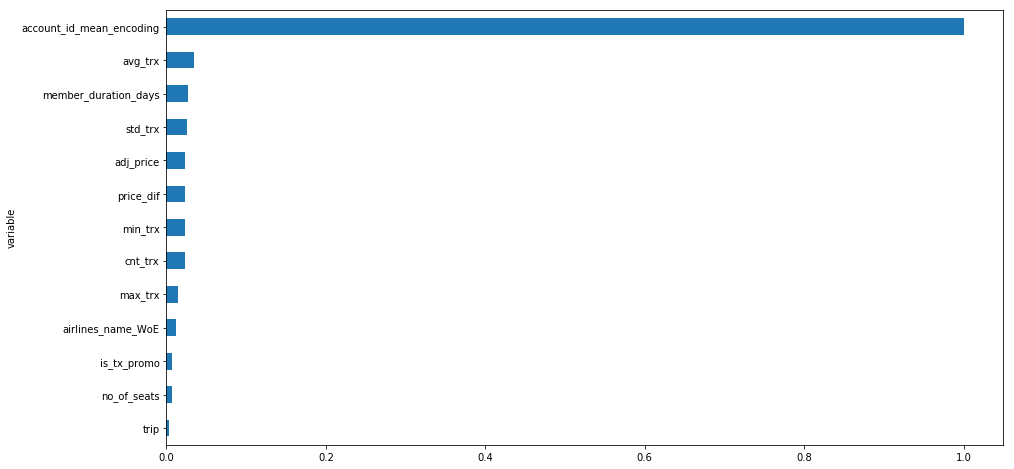

gbm prediction progress: |████████████████████████████████████████████████| 100%


,0,1,2,3,4,mean,std
0.180,0.438444,0.413855,0.409393,0.425139,0.430297,0.423426,0.010623
0.175,0.438156,0.413638,0.408074,0.425610,0.431210,0.423338,0.011080
0.215,0.435469,0.413382,0.413919,0.426956,0.426527,0.423251,0.008464
0.210,0.435589,0.412437,0.414423,0.427968,0.425653,0.423214,0.008662
0.225,0.435107,0.412903,0.415704,0.426540,0.425695,0.423190,0.008017
...,...,...,...,...,...,...,...
0.020,0.206025,0.280270,0.224913,0.222151,0.190328,0.224737,0.030413
0.015,0.187711,0.251840,0.205190,0.198044,0.174695,0.203496,0.026262
0.010,0.168404,0.214540,0.185296,0.171950,0.158859,0.179810,0.019324
0.005,0.156899,0.167840,0.161650,0.158586,0.151825,0.159360,0.005303


In [0]:
tune_df=cross_val(df_raw,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell') & (x!='order_id') & (x!='cnt_trx') & (x!='airlines_name')],
                  f1_threshold=np.arange(0.0,0.45,0.005),params=params_GBM,nfolds=5,model='gbm',is_feat_eng=True,is_binning=False,is_WoE=True,adjusted_WoE=True,
                  is_mean_encode=True,adjusted_mean=False,is_segment=False,is_PMI=False,is_embedding=False)
tune_df.sort_values(by='mean',ascending=False)

In [0]:
best_f1_GBM=tune_df.sort_values(by='mean',ascending=False).index[0]

# Ensemble Tuning

Finding the best threshold so we got the highest F1-Score using ensemble model

In [0]:
hasil_ensemble = cross_val_ensemble(df,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell') & (x!='order_id') & (x!='cnt_trx') & (x!='airlines_name')],
                                    model1='DRF',model2='GBM',f1_threshold=np.arange(0,0.45,0.005),
                                    nfolds=5,is_feat_eng=True,is_binning=False,is_WoE=True,adjusted_WoE=True,
                                    is_mean_encode=True,adjusted_mean=False,is_segment=False)
hasil_ensemble.sort_values(by='mean',ascending=False)

Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
stackedensemble Model Build progress: |███████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
Done Feature Engineering!
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
stackedensemble Model Build progress: |███████████████████████████████████| 100%
stackedensemble prediction progress: |███████████████████

,0,1,2,3,4,mean,std
0.075,0.439742,0.415043,0.422600,0.427976,0.429581,0.426988,0.008152
0.085,0.438547,0.417127,0.422969,0.425672,0.429259,0.426715,0.007121
0.070,0.438356,0.414382,0.423059,0.427390,0.429505,0.426538,0.007862
0.080,0.438686,0.413699,0.422222,0.426567,0.430005,0.426236,0.008278
0.065,0.436594,0.413179,0.421477,0.426111,0.432932,0.426059,0.008308
...,...,...,...,...,...,...,...
0.025,0.110910,0.113242,0.112392,0.110681,0.108732,0.111191,0.001551
0.020,0.110910,0.113242,0.112392,0.110681,0.108732,0.111191,0.001551
0.015,0.110910,0.113242,0.112392,0.110681,0.108732,0.111191,0.001551
0.010,0.110910,0.113242,0.112392,0.110681,0.108732,0.111191,0.001551


In [0]:
best_f1_ensemble=hasil_ensemble.sort_values(by='mean',ascending=False).index[0]

It can be seen that ensemble model give a higher value of F1-score compared to single model

## Submission

In [0]:
df_test['gender']=df_test['gender'].apply(lambda x: 'M' if x=='None' else x)
df_test['trip']=df_test['trip'].apply(lambda x: 'round' if x=='roundtrip' else x)
df_test['airlines_name']=df_test['airlines_name'].apply(lambda x: 'A' if x=='6c483c0812c96f8ec43bb0ff76eaf716' else 'B' if x=='33199710eb822fbcfd0dc793f4788d30' else 'C' if x=='0a102015e48c1f68e121acc99fca9a05' else 
                          'D' if x=='ad5bef60d81ea077018f4d50b813153a' else 'E' if x=='74c5549aa99d55280a896ea50068a211' else 'F' if x=='e35de6a36d385711a660c72c0286154a' else 'G' if x=='9855a1d3de1c46526dde37c5d6fb758c' else 'H')
df_test['log_transaction']=df_test['log_transaction'].apply(lambda x: ast.literal_eval(x))
df_test['log_transaction']=df_test['log_transaction'].apply(lambda x: ast.literal_eval(x))

print('Checking Negative Trx: ')
print(df_test['log_transaction'].apply(lambda x: "Negative" if any(k<0 for k in x) else "Positive").value_counts())

df_test['is_refund']=df_test['log_transaction'].apply(lambda x: "Yes" if any(k<0 for k in x) else "No")
df_test['min_trx']=df_test['log_transaction'].apply(lambda x: np.min(x))
df_test['max_trx']=df_test['log_transaction'].apply(lambda x: np.max(x))
df_test['avg_trx']=df_test['log_transaction'].apply(lambda x: np.mean(x))
df_test['std_trx']=df_test['log_transaction'].apply(lambda x: np.std(x))
df_test['cnt_trx']=df_test['log_transaction'].apply(lambda x: len(x))
df_test['visited_jogja']=df_test['visited_city'].apply(lambda x: 1 if 'Jogjakarta' in x else 0)
df_test['visited_semarang']=df_test['visited_city'].apply(lambda x: 1 if 'Semarang' in x else 0)
df_test['visited_surabaya']=df_test['visited_city'].apply(lambda x: 1 if 'Surabaya' in x else 0)
df_test['visited_aceh']=df_test['visited_city'].apply(lambda x: 1 if 'Aceh' in x else 0)
df_test['visited_manado']=df_test['visited_city'].apply(lambda x: 1 if 'Manado' in x else 0)

df_test['adj_price']=df_test['price']/(df_test['no_of_seats'])
df_test['adj_price']=df_test.apply(lambda x: (x.adj_price)/2 if x.trip=='round' else x.adj_price ,axis=1)

an = df_test.airlines_name.unique()
sc = df_test.service_class.unique()
a=dict()
for i in an:
  for j in sc:
    mean_g = np.mean(df_test[(df_test.airlines_name==i)&(df_test.service_class==j)&(df_test.is_tx_promo=='NO')]['adj_price'])
    a[i+'_'+j]=mean_g
df_test['price_dif']=df_test.apply(lambda x : ((x.adj_price) - a['A_ECONOMY']) if ((x.airlines_name=='A') & (x.service_class=='ECONOMY')) else 
                         ((x.adj_price) - a['B_ECONOMY']) if ((x.airlines_name=='B') & (x.service_class=='ECONOMY')) else 
                         ((x.adj_price) - a['C_ECONOMY']) if ((x.airlines_name=='C') & (x.service_class=='ECONOMY')) else 
                         ((x.adj_price) - a['D_ECONOMY']) if ((x.airlines_name=='D') & (x.service_class=='ECONOMY')) else 
                         ((x.adj_price) - a['E_BUSINESS']) if ((x.airlines_name=='E') & (x.service_class=='BUSINESS')) else 
                         ((x.adj_price) - a['E_ECONOMY']) if ((x.airlines_name=='E') & (x.service_class=='ECONOMY')) else 
                         ((x.adj_price) - a['F_ECONOMY']) if ((x.airlines_name=='F') & (x.service_class=='ECONOMY')) else 
                         np.nan ,axis=1)
df_test=df_test.drop(['log_transaction','visited_city','route'],1)

Checking Negative Trx: 
Positive    9993
Negative       7
Name: log_transaction, dtype: int64


Berikut adalah pendefinisian fungsi untuk submission

In [0]:
def submission_ensemble(df_train,df_test,drop_columns,f1_threshold,model1='DRF',model2='GBM',is_feat_eng=False,label_not_cross_sell=False,is_binning=True,is_WoE=True,adjusted_WoE=True,is_mean_encode=True):
  df_train=df_train.drop(drop_columns,1)
  df_test=df_test.drop(drop_columns,1)
  #Feature Engineering
  if is_feat_eng:
    if label_not_cross_sell:
      #Creating list of customer which has number of orders more than 50
      acc=pd.DataFrame(df_train['account_id'].value_counts())
      top_acc_list=acc[acc.account_id>50].index.tolist()
      #Creating list of customer which never done cross selling
      toy=df_train.copy()
      toy['is_cross_sell']=toy['is_cross_sell'].apply(lambda x: 1 if x=='Yes' else 0)
      cross_sell_prop=pd.DataFrame(toy.groupby('account_id').mean()['is_cross_sell'])
      no_cross_sell_list=cross_sell_prop[cross_sell_prop['is_cross_sell']==0].index.tolist()
      #Creating  list of customer which has number of orders more than 50 and never done cross selling
      not_cross_sell_account_id=df_train[(df_train['account_id'].isin(top_acc_list)) & (df_train['account_id'].isin(no_cross_sell_list))]['account_id'].unique().tolist()

      df_train['label_not_cross_sell']=df_train['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
      df_test['label_not_cross_sell']=df_test['account_id'].apply(lambda x: 1 if x in not_cross_sell_account_id else 0)
    if is_WoE:
      df_train,df_test=WoE(df_train,df_test,columns=['airlines_name'],target='is_cross_sell',adjusted=adjusted_WoE)
    if is_mean_encode:
      df_train,df_test=mean_encoding(df_train,df_test,columns=['account_id'],target='is_cross_sell')
    if is_binning:
      df_train,df_test=detailed_segmentation(df_train,df_test,columns=['member_duration_days','price'],target='is_cross_sell',num_segments=5)
    if 'account_id' in df_train.columns:
      df_train,df_test=df_train.drop('account_id',1),df_test.drop('account_id',1)
    print('Done Feature Engineering!')
  else:
    df_train,df_test=df_train.drop('account_id',1),df_test.drop('account_id',1)

  print(df_train.columns)
  df_train_h2o = h2o.H2OFrame(df_train)
  df_test_h20 = h2o.H2OFrame(df_test)
  #specify the target and predictor variable
  x=df_train.drop('is_cross_sell',1).columns.tolist()
  y='is_cross_sell'

  #Initiate Model
  if model1=='DRF':
    model_1 = H2ORandomForestEstimator(**params_DRF)
  elif model1=='GBM':
    model_1 = H2OGradientBoostingEstimator(**params_GBM)
  else: 
    raise ValueError('Model tidak terdaftar')
  model_1.train(x = x, y = y, training_frame = df_train_h2o)

  if model2=='DRF':
    model_2 = H2ORandomForestEstimator(**params_DRF)
  elif model2=='GBM':
    model_2 = H2OGradientBoostingEstimator(**params_GBM)
  else: 
    raise ValueError('Model tidak terdaftar')
  model_2.train(x = x, y = y, training_frame = df_train_h2o)

  list_models=[model_1, model_2]

  ensemble = H2OStackedEnsembleEstimator(base_models=list_models)
  ensemble.train(x = x, y = y, training_frame = df_train_h2o)

  prediction = ensemble.predict(df_test_h20)[:,2]
  prediction=prediction.as_data_frame()['Yes']
  prediction=prediction.apply(lambda x: "Yes" if x>f1_threshold else "No")
  submission=df_test[['order_id']]
  submission['is_cross_sell']=prediction
  return(submission)

In [0]:
  submission=submission_ensemble(df,df_test,drop_columns=[x for x in drop_columns if (x!='account_id') & (x!='is_cross_sell') & (x!='order_id') & (x!='cnt_trx') & (x!='airlines_name')]
                                 ,f1_threshold=best_f1_ensemble,model1='DRF',model2='GBM',
                                 is_feat_eng=True,is_binning=False,is_WoE=True,adjusted_WoE=True,is_mean_encode=True)

In [0]:
submission.to_csv('final_submission_buncit.csv',index=False)